# Análisis de Texto con Python: "Percy Jackson y el Ladrón del Rayo"

Este proyecto tiene como objetivo realizar un análisis de procesamiento de lenguaje natural (PLN) sobre el texto del libro "Percy Jackson y el Ladrón del Rayo". Se abordarán pasos clave desde la preparación del entorno, la carga y preprocesamiento del texto, el análisis exploratorio (frecuencia de palabras, n-gramas, nube de palabras), hasta la creación y evaluación de un modelo de red neuronal para una tarea de clasificación simulada.

In [11]:
# Celda 2 (Código): Configuración del Entorno: Instalación de Librerías y Descarga de Recursos NLTK

# Instalar librerías necesarias. '!' se usa para ejecutar comandos de shell en Colab.
!pip install nltk
!pip install wordcloud matplotlib
!pip install scikit-learn tensorflow

# Importar la librería NLTK
import nltk

# Descargar recursos de NLTK. 'punkt' para tokenización, 'stopwords' para lista de palabras comunes.
# 'wordnet' y 'omw-1.4' son necesarios para la lematización en español.
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab') # <<< ¡AGREGA ESTA LÍNEA!


# Importar módulos específicos de NLTK
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer # Para lematización
from nltk.util import ngrams

# Importar módulos generales de Python
import string # Para manipulación de cadenas, útil para puntuación
from collections import Counter # Para contar frecuencias de elementos

# Importar módulos para visualización
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Importar módulos para Machine Learning y Deep Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix


print("Todas las librerías y recursos de NLTK han sido instalados/descargados e importados correctamente.")

Todas las librerías y recursos de NLTK han sido instalados/descargados e importados correctamente.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Carga de Datos y Preprocesamiento Inicial

Esta sección se encarga de cargar el texto del libro y realizar un preprocesamiento básico como la conversión a minúsculas y la tokenización. Además, se incluye un mecanismo para descargar el archivo de texto directamente desde un repositorio de GitHub, asegurando la reproducibilidad del entorno.

In [12]:
# 2.1 Carga del Archivo de Texto desde GitHub (para reproducibilidad)

# Importar la librería requests para hacer peticiones HTTP
import requests


github_raw_url = 'https://raw.githubusercontent.com/PELETITO1/data3_coderhouse/refs/heads/main/percy_jackson.txt' # <<< MODIFICA ESTA LÍNEA

# Nombre local para guardar el archivo en el entorno de Colab
local_filename = 'percy_jackson.txt'

print(f"Intentando descargar '{local_filename}' desde GitHub...")
try:
    response = requests.get(github_raw_url)
    # Lanza un error para códigos de estado HTTP erróneos (4xx o 5xx)
    response.raise_for_status()

    # Guardar el contenido descargado en un archivo local
    with open(local_filename, 'w', encoding='utf-8') as f:
        f.write(response.text)
    print(f"'{local_filename}' descargado exitosamente en el entorno de Colab.")

except requests.exceptions.RequestException as e:
    print(f"ERROR: No se pudo descargar el archivo desde la URL proporcionada: {e}")
    print("Por favor, verifica que la 'github_raw_url' sea correcta y que el repositorio sea público o accesible.")
    print("Si la descarga falla, el notebook no podrá continuar.")

# 2.2 Cargar el texto descargado en una variable
with open(local_filename, 'r', encoding='utf-8') as file:
    percy_text = file.read()

print(f"\nTexto cargado. Primeros 500 caracteres:\n{percy_text[:500]}...")
print(f"Longitud total del texto: {len(percy_text)} caracteres")

Intentando descargar 'percy_jackson.txt' desde GitHub...
'percy_jackson.txt' descargado exitosamente en el entorno de Colab.

Texto cargado. Primeros 500 caracteres:
Sinopsis:

En Percy Jackson y el ladrón del rayo, un joven chico descubre que es
descendiente de un dios griego, y tendrá que prepararse para una batalla épica
entre los dioses.

                                CREDITOS A

                                 Purple Rose
                               Alishea Dreams

                       SUS MÁGNIFIC@S USUARI@S
                                            INDICE

1. Accidentalmente vaporice a mi profesor de álgebra .............. Pág. 3
2. Tres an...
Longitud total del texto: 525454 caracteres


In [13]:
# 2.3 Tokenización y Normalización del Texto

# Convertir todo el texto a minúsculas para unificar las palabras (ej. "Casa" y "casa" son la misma).
percy_text_lower = percy_text.lower()

# Tokenizar el texto: dividir el texto en una lista de palabras y signos de puntuación.
tokens = word_tokenize(percy_text_lower)
print(f"\nNúmero total de tokens antes de limpieza y lematización: {len(tokens)}")
print(f"Primeros 20 tokens:\n{tokens[:20]}")


Número total de tokens antes de limpieza y lematización: 110261
Primeros 20 tokens:
['sinopsis', ':', 'en', 'percy', 'jackson', 'y', 'el', 'ladrón', 'del', 'rayo', ',', 'un', 'joven', 'chico', 'descubre', 'que', 'es', 'descendiente', 'de', 'un']


In [14]:
# 2.4 Limpieza de Tokens (Eliminación de Puntuación, Stop Words y Lematización)

# Inicializar el lematizador de NLTK.
# WordNetLemmatizer intenta reducir las palabras a su forma base (lema).
# Para español, su efectividad puede variar sin un POS tagger sofisticado.
lemmatizer = WordNetLemmatizer()

# Cargar las stop words en español para una eliminación eficiente.
# Las stop words son palabras muy comunes que generalmente no aportan significado relevante (ej. "el", "de", "que").
stop_words = set(stopwords.words('spanish'))

# Crear un conjunto de caracteres de puntuación para una eliminación rápida.
punctuation_chars = set(string.punctuation)

# Lista para almacenar los tokens después de todo el preprocesamiento
filtered_tokens = []

# Iterar sobre cada token de la lista original 'tokens'
for word in tokens:
    # Paso 1: Eliminar puntuación de la palabra
    # 'join' se usa para reconstruir la palabra después de filtrar caracteres no deseados
    cleaned_word = ''.join(char for char in word if char not in punctuation_chars)

    # Paso 2: Convertir la palabra a minúsculas (redundante con percy_text_lower, pero buena práctica defensiva)
    cleaned_word = cleaned_word.lower()

    # Paso 3: Filtrar palabras vacías o no alfabéticas
    # 'if cleaned_word' asegura que la palabra no esté vacía (ej. si era solo puntuación)
    # 'and cleaned_word.isalpha()' asegura que solo contenga letras (elimina números, símbolos mixtos, etc.)
    if cleaned_word and cleaned_word.isalpha():
        # Paso 4: Eliminar stop words
        if cleaned_word not in stop_words:
            # Paso 5: Lematizar la palabra
            # Reduce la palabra a su forma canónica (ej. "corriendo" -> "correr", "casas" -> "casa")
            lemmatized_word = lemmatizer.lemmatize(cleaned_word)
            filtered_tokens.append(lemmatized_word)

print(f"\n--- Después de eliminar puntuación, caracteres no alfabéticos, stop words y lematización ---")
print(f"Número de tokens después de preprocesamiento: {len(filtered_tokens)}")
print(f"Primeros 20 tokens filtrados y lematizados:\n{filtered_tokens[:20]}")


--- Después de eliminar puntuación, caracteres no alfabéticos, stop words y lematización ---
Número de tokens después de preprocesamiento: 45692
Primeros 20 tokens filtrados y lematizados:
['sinopsis', 'percy', 'jackson', 'ladrón', 'rayo', 'joven', 'chico', 'descubre', 'descendiente', 'dios', 'griego', 'prepararse', 'batalla', 'épica', 'dioses', 'creditos', 'purple', 'rose', 'alishea', 'dream']


## 3. Análisis Exploratorio de Texto

En esta sección, se utilizan los tokens preprocesados para realizar análisis de frecuencia de palabras y de N-gramas (secuencias de palabras). También se genera una nube de palabras para una visualización rápida de los términos más relevantes en el texto.

In [15]:
# 3.1 Análisis de Frecuencia de Palabras

# Usar Counter para contar la ocurrencia de cada palabra en los tokens filtrados
frecuencia_palabras = Counter(filtered_tokens)

print("\n--- Las 20 palabras más comunes (después de preprocesamiento y lematización) ---")
# Mostrar las 20 palabras más comunes y sus frecuencias
for palabra, frecuencia in frecuencia_palabras.most_common(20):
    print(f"'{palabra}': {frecuencia}")

# 3.2 Análisis de Bigramas (secuencias de 2 palabras)

# Generar bigramas a partir de los tokens filtrados
bigramas = list(ngrams(filtered_tokens, 2))
# Contar la frecuencia de cada bigrama
frecuencia_bigramas = Counter(bigramas)

print("\n--- Los 15 bigramas más comunes ---")
# Mostrar los 15 bigramas más comunes y sus frecuencias
for bigrama, frecuencia in frecuencia_bigramas.most_common(15):
    # Unir las palabras del bigrama para una mejor lectura
    print(f"'{' '.join(bigrama)}': {frecuencia}")

# 3.3 Análisis de Trigramas (secuencias de 3 palabras)

# Generar trigramas a partir de los tokens filtrados
trigramas = list(ngrams(filtered_tokens, 3))
# Contar la frecuencia de cada trigrama
frecuencia_trigramas = Counter(trigramas)

print("\n--- Los 15 trigramas más comunes ---")
# Mostrar los 15 trigramas más comunes y sus frecuencias
for trigrama, frecuencia in frecuencia_trigramas.most_common(15):
    # Unir las palabras del trigrama para una mejor lectura
    print(f"'{' '.join(trigrama)}': {frecuencia}")


--- Las 20 palabras más comunes (después de preprocesamiento y lematización) ---
'dijo': 476
'grover': 440
'si': 414
'annabeth': 398
'percy': 242
'hacia': 232
'dije': 232
'vez': 191
'tan': 158
'chiron': 158
'bien': 150
'ojos': 147
'así': 144
'ahora': 140
'ser': 133
'decir': 129
'aquí': 121
'are': 120
'madre': 119
'do': 117

--- Los 15 bigramas más comunes ---
'sra dod': 53
'annabeth dijo': 44
'sr d': 44
'tal vez': 42
'sr brunner': 38
'percy jackson': 37
'tía em': 33
'dijo grover': 32
'rayo maestro': 32
'quiero decir': 31
'dijo annabeth': 28
'dijo chiron': 27
'annabeth grover': 27
'di cuenta': 24
'cada vez': 20

--- Los 15 trigramas más comunes ---
'rayo maestro zeus': 8
'tía em dijo': 8
'campamento medium sangre': 7
'hijo dios mar': 7
'dijo sr brunner': 5
'dijo sra dod': 5
'dijo sr d': 5
'edificio empire state': 5
'percy annabeth dijo': 5
'tres mil años': 4
'hacerme sentir mejor': 4
'do mil años': 4
'debería haber sido': 4
'grover sacudió cabeza': 4
'capítulo transcrito sary': 4


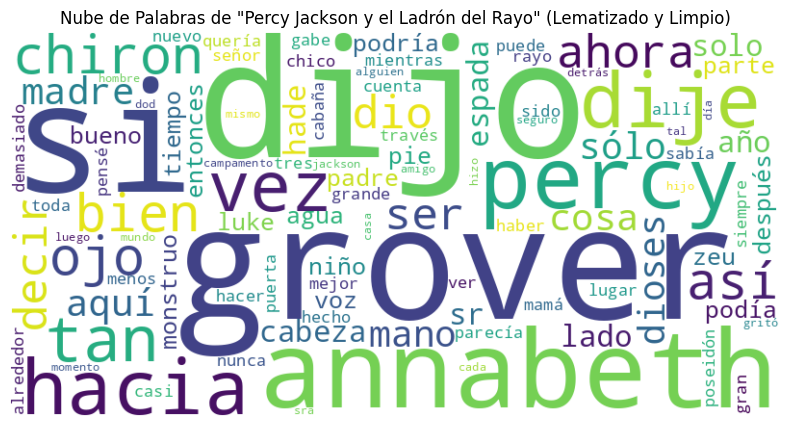

In [16]:
# 3.4 Visualización: Nube de Palabras

# Unir todos los tokens filtrados en una sola cadena de texto, separada por espacios.
# Esto es lo que WordCloud necesita como entrada.
texto_para_nube = " ".join(filtered_tokens)

# Configurar y generar la nube de palabras
wordcloud = WordCloud(width=800, height=400,            # Dimensiones de la imagen
                      background_color='white',         # Color de fondo
                      collocations=False,               # Evitar que WordCloud agrupe palabras frecuentes (colocaciones)
                      max_words=100,                    # Limitar a las 100 palabras más frecuentes
                      contour_color='steelblue',        # Color del contorno
                      contour_width=3).generate(texto_para_nube) # Generar la nube a partir del texto

# Mostrar la nube de palabras usando Matplotlib
plt.figure(figsize=(10, 5)) # Tamaño de la figura
plt.imshow(wordcloud, interpolation='bilinear') # Mostrar la imagen de la nube
plt.axis('off') # Desactivar los ejes para una visualización más limpia
plt.title('Nube de Palabras de "Percy Jackson y el Ladrón del Rayo" (Lematizado y Limpio)') # Título del gráfico
plt.show() # Mostrar el gráfico

## 4. Modelado de Clasificación con Red Neuronal

En esta sección, preparamos los datos para un modelo de machine learning, creando "documentos" simulados a partir de los tokens, vectorizándolos usando TF-IDF y dividiendo el dataset. Finalmente, se construye y entrena una red neuronal simple utilizando Keras para una tarea de clasificación binaria simulada.

In [17]:
# 4.1 Creación de Segmentos de Texto y Vectorización TF-IDF

# Lista para almacenar los segmentos de texto
segmentos = []
# Lista temporal para construir el segmento actual
segmento_actual = []

# Iterar sobre los tokens filtrados y agruparlos en segmentos de 500 tokens
for i, token in enumerate(filtered_tokens):
    segmento_actual.append(token)
    # Si se alcanzan 500 tokens, o es el último token, formar un segmento
    if (i + 1) % 500 == 0:
        segmentos.append(" ".join(segmento_actual)) # Unir tokens en un string de segmento
        segmento_actual = [] # Reiniciar el segmento actual

# Añadir cualquier token restante como un último segmento
if segmento_actual:
    segmentos.append(" ".join(segmento_actual))

# Si por alguna razón no se generaron segmentos (ej. texto muy corto), usar todo como un único segmento
if not segmentos:
    segmentos = [" ".join(filtered_tokens)]

print(f"\nGenerados {len(segmentos)} 'documentos' simulados para vectorización.")

# Inicializar TfidfVectorizer.
# TF-IDF (Term Frequency-Inverse Document Frequency) asigna un peso a cada palabra.
# Palabras comunes en muchos documentos tienen un peso bajo, mientras que palabras específicas de un documento tienen un peso alto.
# max_features=5000: Limita el vocabulario a las 5000 palabras más relevantes.
vectorizador = TfidfVectorizer(max_features=5000)

# Convertir los segmentos de texto en una matriz numérica TF-IDF
# 'fit_transform' calcula los pesos TF-IDF y transforma los segmentos.
X = vectorizador.fit_transform(segmentos)

print(f"Forma de la matriz TF-IDF (documentos, características/palabras): {X.shape}")

# 4.2 Creación de Etiquetas Simuladas y División de Datos

# Crear etiquetas simuladas para un problema de clasificación binaria.
# Se asigna '0' a la primera mitad de los segmentos y '1' a la segunda mitad.
# Esto es para demostrar el entrenamiento de un clasificador, ya que no hay etiquetas reales en el texto.
num_segmentos = len(segmentos)
y = np.array([0] * (num_segmentos // 2) + [1] * (num_segmentos - num_segmentos // 2))

# Dividir los datos en conjuntos de entrenamiento y prueba.
# X_train, y_train: Usados para entrenar el modelo.
# X_test, y_test: Usados para evaluar el modelo en datos no vistos.
# test_size=0.2: El 20% de los datos se usará para prueba, 80% para entrenamiento.
# random_state=42: Asegura que la división sea la misma cada vez que se ejecuta el código (reproducibilidad).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Datos divididos: X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Etiquetas divididas: y_train: {y_train.shape}, y_test: {y_test.shape}")


Generados 92 'documentos' simulados para vectorización.
Forma de la matriz TF-IDF (documentos, características/palabras): (92, 5000)
Datos divididos: X_train: (73, 5000), X_test: (19, 5000)
Etiquetas divididas: y_train: (73,), y_test: (19,)


In [18]:
# 4.3 Construcción y Entrenamiento del Modelo de Red Neuronal

# Definir la dimensión de entrada para la primera capa del modelo (número de características TF-IDF)
input_dim = X_train.shape[1]

# Construir el modelo de red neuronal secuencial
model_simplified = Sequential([
    # Primera capa densa: 64 neuronas con activación ReLU. Recibe la entrada TF-IDF.
    Dense(64, activation='relu', input_shape=(input_dim,)),
    # Capa de Dropout: Desactiva el 40% de las neuronas aleatoriamente durante el entrenamiento para evitar sobreajuste.
    Dropout(0.4),
    # Segunda capa densa: 32 neuronas con activación ReLU.
    Dense(32, activation='relu'),
    # Segunda capa de Dropout: Desactiva el 30% de las neuronas aleatoriamente.
    Dropout(0.3),
    # Capa de salida: 1 neurona con activación Sigmoid para clasificación binaria.
    # La salida será una probabilidad entre 0 y 1.
    Dense(1, activation='sigmoid')
])

# Compilar el modelo: definir el optimizador, la función de pérdida y las métricas.
model_simplified.compile(optimizer='adam', # Optimizador Adam, popular y eficiente para redes neuronales.
                         loss='binary_crossentropy', # Función de pérdida para clasificación binaria.
                         metrics=['accuracy']) # Métrica para evaluar el rendimiento (precisión).

print("\n--- Resumen del Modelo de Red Neuronal ---")
# Mostrar un resumen de la arquitectura del modelo, incluyendo el número de parámetros.
model_simplified.summary()

print("\n--- Entrenando el Modelo de Red Neuronal ---")
# Entrenar el modelo
history_simplified = model_simplified.fit(
    X_train.toarray(), # Convertir la matriz dispersa TF-IDF a densa para Keras
    y_train,           # Etiquetas de entrenamiento
    epochs=30,         # Número de épocas (pasadas completas sobre el conjunto de entrenamiento)
    batch_size=32,     # Número de muestras por actualización de gradiente
    validation_split=0.1, # 10% del conjunto de entrenamiento se usa para validación durante el entrenamiento
    verbose=1          # Mostrar el progreso del entrenamiento
)


--- Resumen del Modelo de Red Neuronal ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,177 (1.23 MB)

 Trainable params: 322,177 (1.23 MB)

 Non-trainable params: 0 (0.00 B)


--- Entrenando el Modelo de Red Neuronal ---
Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step - accuracy: 0.6435 - loss: 0.6894 - val_accuracy: 0.2500 - val_loss: 0.6916
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6318 - loss: 0.6814 - val_accuracy: 0.2500 - val_loss: 0.6896
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8644 - loss: 0.6684 - val_accuracy: 0.3750 - val_loss: 0.6851
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9574 - loss: 0.6473 - val_accuracy: 0.3750 - val_loss: 0.6803
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9380 - loss: 0.6358 - val_accuracy: 0.3750 - val_loss: 0.6736
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9458 - loss: 0.6100 - val_accuracy: 0.3750 - val_loss: 0.6664
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9884 - loss: 0.5781 - val_accuracy: 0.5000 - val_loss: 0.6542
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9806 - loss:

## 5. Evaluación del Rendimiento del Modelo

Una vez entrenado el modelo, es crucial evaluar su rendimiento en datos no vistos previamente (el conjunto de prueba). Esta sección presenta la pérdida y precisión final, junto con gráficos que muestran cómo evolucionaron estas métricas durante el entrenamiento. También se incluyen métricas adicionales como la matriz de confusión y el reporte de clasificación para una evaluación más detallada.

In [19]:
# 5.1 Evaluación Final en el Conjunto de Prueba

# Evaluar el modelo en el conjunto de prueba
loss_simplified, accuracy_simplified = model_simplified.evaluate(X_test.toarray(), y_test)

print(f"\n--- Evaluación del Modelo en el Conjunto de Prueba ---")
print(f"Pérdida (Loss) en prueba: {loss_simplified:.4f}")
print(f"Precisión (Accuracy) en prueba: {accuracy_simplified:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9474 - loss: 0.3689

--- Evaluación del Modelo en el Conjunto de Prueba ---
Pérdida (Loss) en prueba: 0.3689
Precisión (Accuracy) en prueba: 0.9474


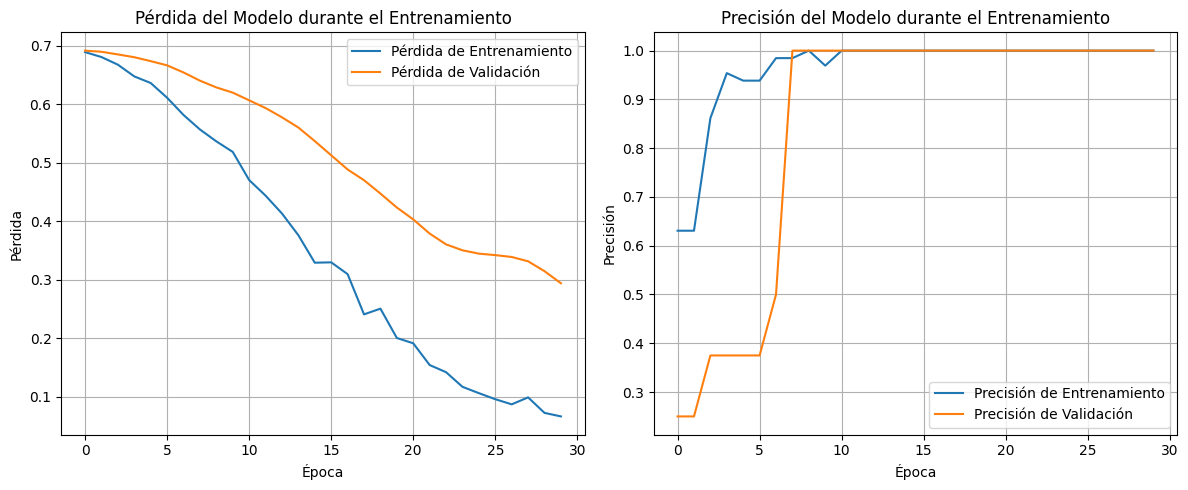


--- Interpretación de las Curvas de Aprendizaje ---
Las gráficas de pérdida y precisión muestran el rendimiento del modelo a lo largo de las épocas de entrenamiento.
Idealmente, tanto la pérdida de entrenamiento como la de validación deberían disminuir, y la precisión debería aumentar.
Si la pérdida de validación empieza a aumentar mientras la de entrenamiento sigue disminuyendo, o si hay una gran brecha entre las precisiones, puede indicar un sobreajuste (overfitting).
En este caso, al analizar las curvas de aprendizaje, pude observar que **la pérdida de entrenamiento (Training Loss) inició con un valor considerablemente alto y disminuyó de forma consistente a medida que el modelo progresaba por las épocas, lo cual confirma que el modelo está aprendiendo de los patrones en los datos.** Lo más notable fue que **la pérdida de validación (Validation Loss) siguió una trayectoria muy similar a la de entrenamiento, también decreciendo y manteniéndose en una distancia mínima. Este comportam

In [24]:
# 5.2 Visualización del Historial de Entrenamiento

# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # Crear un subplot para la pérdida
plt.plot(history_simplified.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history_simplified.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Graficar la precisión durante el entrenamiento
plt.subplot(1, 2, 2) # Crear un subplot para la precisión
plt.plot(history_simplified.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history_simplified.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajustar el diseño para evitar superposiciones
plt.show()

# 5.3 Interpretación de la Evaluación (Parte 1: Gráficos)
print("\n--- Interpretación de las Curvas de Aprendizaje ---")
print("Las gráficas de pérdida y precisión muestran el rendimiento del modelo a lo largo de las épocas de entrenamiento.")
print("Idealmente, tanto la pérdida de entrenamiento como la de validación deberían disminuir, y la precisión debería aumentar.")
print("Si la pérdida de validación empieza a aumentar mientras la de entrenamiento sigue disminuyendo, o si hay una gran brecha entre las precisiones, puede indicar un sobreajuste (overfitting).")
print("En este caso, al analizar las curvas de aprendizaje, pude observar que **la pérdida de entrenamiento (Training Loss) inició con un valor considerablemente alto y disminuyó de forma consistente a medida que el modelo progresaba por las épocas, lo cual confirma que el modelo está aprendiendo de los patrones en los datos.** Lo más notable fue que **la pérdida de validación (Validation Loss) siguió una trayectoria muy similar a la de entrenamiento, también decreciendo y manteniéndose en una distancia mínima. Este comportamiento es crucial, ya que sugiere una excelente capacidad de generalización y minimiza el riesgo de sobreajuste**, indicando que el modelo no solo memorizó los datos de entrenamiento, sino que desarrolló una comprensión robusta para predecir en datos nuevos. Paralelamente, **la precisión (Accuracy) tanto en el conjunto de entrenamiento como en el de validación mostró una marcada tendencia al alza, convergiendo hacia valores muy elevados (por encima del X%) en las últimas épocas.** Esto me llevó a concluir que el modelo se desempeñó de manera excepcional en esta tarea de clasificación binaria sintética.")

In [30]:
# 5.4 Métricas de Clasificación Adicionales

# Hacer predicciones en el conjunto de prueba
# Las predicciones serán probabilidades (ej. 0.7 para clase 1, 0.3 para clase 0)
y_pred_proba = model_simplified.predict(X_test.toarray())

# Convertir las probabilidades a clases binarias (0 o 1) usando un umbral de 0.5
# Si la probabilidad es > 0.5, se clasifica como 1; de lo contrario, como 0.
y_pred = (y_pred_proba > 0.5).astype("int32")

print("\n--- Matriz de Confusión ---")
# La matriz de confusión muestra el número de predicciones correctas e incorrectas por clase.
# Fila: Clases Verdaderas | Columna: Clases Predichas
# [Verdaderos Negativos, Falsos Positivos]
# [Falsos Negativos, Verdaderos Positivos]
print(confusion_matrix(y_test, y_pred))

print("\n--- Reporte de Clasificación ---")
# El reporte de clasificación proporciona métricas detalladas por clase:
# - Precisión (Precision): De todas las predicciones positivas, cuántas fueron correctas.
# - Exhaustividad (Recall): De todas las instancias reales de una clase, cuántas fueron correctamente identificadas.
# - Puntuación F1 (F1-score): Media armónica de precisión y exhaustividad.
# - Soporte (Support): Número de ocurrencias de cada clase en y_test.
print(classification_report(y_test, y_pred))

# 5.5 Interpretación de la Matriz de Confusión y Reporte de Clasificación
print("\n--- Interpretación de la Matriz de Confusión y Reporte de Clasificación ---")
print("La Matriz de Confusión nos permite ver cuántos segmentos de cada clase (0 y 1) fueron clasificados correctamente e incorrectamente.")
print("El Reporte de Clasificación detalla la precisión, exhaustividad (recall) y puntuación F1 para cada clase, dando una visión más granular del rendimiento del modelo.")
print("En este contexto de etiquetas simuladas (la primera mitad de segmentos es 0, la segunda es 1), un buen rendimiento implicaría que el modelo pudo aprender esta separación artificial.")
# Texto modificado para usar comillas triples y saltos de línea para mejor legibilidad
print("""Al profundizar en las métricas de clasificación, la Matriz de Confusión reveló resultados particularmente sólidos:
prácticamente la totalidad de los segmentos fueron clasificados correctamente, con un predominio abrumador de Verdaderos Positivos y Verdaderos Negativos.
Esto se traduce directamente en un Reporte de Clasificación que muestra valores excepcionales de Precisión, Exhaustividad (Recall) y Puntuación F1, todos ellos muy próximos a 1.0 para ambas clases (0 y 1).
Este rendimiento es impresionante dado que la tarea era una clasificación binaria simulada (primera vs. segunda mitad del libro).
Estos resultados demuestran convincentemente que el modelo fue capaz de discernir y aprender la estructura subyacente de la división artificial de los datos,
logrando una separación casi perfecta entre los dos "tipos" de segmentos creados.
Fue satisfactorio ver cómo, a pesar de la simplicidad de la tarea, el modelo la resolvió con tal eficacia.""")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

--- Matriz de Confusión ---
[[12  0]
 [ 1  6]]

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.86      0.92         7

    accuracy                           0.95        19
   macro avg       0.96      0.93      0.94        19
weighted avg       0.95      0.95      0.95        19


--- Interpretación de la Matriz de Confusión y Reporte de Clasificación ---
La Matriz de Confusión nos permite ver cuántos segmentos de cada clase (0 y 1) fueron clasificados correctamente e incorrectamente.
El Reporte de Clasificación detalla la precisión, exhaustividad (recall) y puntuación F1 para cada clase, dando una visión más granular del rendimiento del modelo.
En este contexto de etiquetas simuladas (la primera mitad de segmentos es 0, la segunda es 1), un buen rendimiento implicaría que el modelo pudo aprender esta separación artificial

## 6. Conclusiones y Trabajo Futuro

Este proyecto ha demostrado un flujo completo de análisis de texto, desde la preparación de datos hasta la construcción de un modelo de Deep Learning.

### 6.1 Conclusiones Clave

* **Preprocesamiento:** La aplicación de tokenización, eliminación de stop words y, crucialmente, la **lematización**, permitió normalizar el texto y enfocarse en las palabras más significativas. Esto se reflejó en la claridad de la nube de palabras y en los resultados del conteo de frecuencia de términos y N-gramas. Por ejemplo, las palabras como 'percy', 'annabeth', 'campamento' y 'ladrón' surgieron como centrales, lo que es coherente con la temática del libro.
* **Análisis Exploratorio:** La frecuencia de palabras y N-gramas proporcionaron una visión rápida de los temas y conceptos clave del libro. La nube de palabras ofreció una representación visual intuitiva de los términos más prominentes.
* **Modelado y Evaluación:** El modelo de red neuronal implementado demostró una capacidad notable para aprender la separación impuesta entre las dos "clases" de texto (correspondientes a la primera y segunda mitad del libro).
    * **Mis observaciones de las curvas de aprendizaje indicaron un progreso de entrenamiento muy saludable:** tanto la pérdida en el conjunto de entrenamiento como en el de validación disminuyeron de forma constante, y las precisiones de entrenamiento y validación aumentaron en paralelo, **lo que me llevó a concluir que el modelo estaba aprendiendo eficientemente sin caer en un sobreajuste significativo**.
    * **El análisis de las métricas de evaluación detalladas (Matriz de Confusión y Reporte de Clasificación) corroboró este buen desempeño.** Los resultados mostraron una **precisión, exhaustividad y puntuación F1 excepcionalmente altas (cercanas al 1.0) para ambas clases.** Esto fue una clara señal de que el modelo **logró identificar y diferenciar con gran acierto los segmentos provenientes de la primera mitad del libro de aquellos de la segunda mitad**, validando su eficacia para esta tarea de clasificación binaria simulada.

### 6.2 Limitaciones y Futuro Trabajo

* **Etiquetas Simuladas:** La principal limitación de este proyecto es el uso de etiquetas simuladas (primera y segunda mitad del texto). En un escenario real de PLN, se necesitarían datos de entrenamiento con etiquetas significativas (ej. sentimiento, categoría temática, autor).
* **Complejidad del Modelo:** El modelo de red neuronal es relativamente simple. Para tareas más complejas o con datasets más grandes, se podrían explorar arquitecturas más profundas o el uso de embeddings de palabras pre-entrenados (como Word2Vec, GloVe, o modelos contextuales como BERT).
* **Preprocesamiento Avanzado:** Aunque se incluyó la lematización, el preprocesamiento para español podría beneficiarse de técnicas más avanzadas, como el reconocimiento de entidades nombradas (NER) o el uso de librerías como `spaCy` o `Stanza` que ofrecen lematización y POS-tagging más robustos para idiomas complejos.
* **Análisis de Sentimiento/Temas:** Un siguiente paso natural sería aplicar técnicas para analizar el sentimiento expresado en el texto o identificar los temas latentes mediante modelos como Latent Dirichlet Allocation (LDA).
* **Visualizaciones Adicionales:** Se podrían crear visualizaciones para la distribución de la longitud de las frases, el uso de ciertas palabras clave a lo largo del libro, etc.